The ground state consists of all spins alligned in same state. Thus ground state energy is −𝐽 for every edge and since there are 4N edges considering N total sites and periodic boundary conditions, total energy will be −4𝑁𝐽. Since all spins are in same state magnetization per site will be 1.

As $lim_{\rightarrow \infty}T$ both $\langle E \rangle$ and $\langle M \rangle$ tends to zero. The neighbouring spins will be aligned in an alternate way summing up to zero and sum of neighbous for any given site also becomes zero.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import generate_binary_structure
from scipy.ndimage import convolve
import scipy.stats
import math
import statistics

In [2]:
L = 20
N = L * L
T1 = 0.1

Create a random lattice of size L of 1 or -1 with given probability. Here 1 and -1 represents spin in upwards and downwards direction respectively.

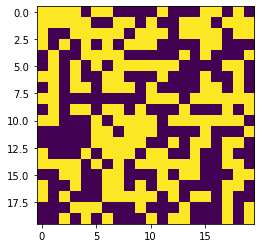

In [3]:
p = 0.5
Lattice = np.random.choice([1, -1], size=(L,L), p=[p, 1-p])
plt.imshow(Lattice)
plt.show()

Energy of a lattice in an icing model is given by:
    \begin{equation}
    E = -J\sum_{\langle i,j \rangle}s_is_j \Rightarrow E' = E/J = -\sum_{\langle i,j \rangle}s_is_j
    \end{equation}
Where $\langle i,j \rangle$ denotes the sum in neigherest neighbour and $s_i$ and $s_j$ denotes the spin in $i^{th}$ and $j^{th}$ cell. Function Energy() evaluates the above expression for a given state of the system asuming periodic boundary conditions. 

In [4]:
#Energy Function
def Energy(Lattice):
    kernel = generate_binary_structure(2, 1) 
    kernel[1][1] = False
    array = -Lattice * convolve(Lattice, kernel, mode='wrap')
    return array.sum()

Magnetization of the system with N cells is defined as:
\begin{equation}
    \langle M \rangle = \frac{1}{N}\left|\sum_{i=1}^Ns_i\right| 
\end{equation}

In [5]:
#Magnetization Function
def Magnetization(Lattice,L):
    return(abs(Lattice.sum()/L**2))

Following function flip one randomly selected spin and evaluates the energy difference. If the Energy difference is negative than the updated lattice is returned else updated lattice is only returned with a probability of $e^{-dE/T'}$.

In [6]:
#Flip Function
def FlipSpin(Lattice,T1,L):
    a = np.random.randint(0, L)
    b = np.random.randint(0, L)
    s =  Lattice[a, b]
    nb = Lattice[(a+1)%L,b] + Lattice[a,(b+1)%L] + Lattice[(a-1)%L,b] + Lattice[a,(b-1)%L]
    dE = 2*s*nb             
    if dE < 0:
        s *= -1
    elif np.random.random() < np.exp(-dE/T1):
        s *= -1
    Lattice[a, b] = s
    return Lattice

Following function attempts to flip the spin N times but not all may be succesful because of the updating rule.

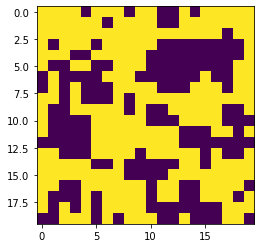

In [7]:
#N attempted site updates
def Nsiteupdate(Lattice,T1,L):
    for i in range(N):
        Lattice = FlipSpin(Lattice,T1,L)
    return Lattice

#Carrying out one system update
Lattice = Nsiteupdate(Lattice,T1,L)
plt.imshow(Lattice)
plt.show()

This function takes a lattice and applies Metropolis algorithm for convergence. Which is done by appling a series of function defined above. It takes a lattice and apply the system update function recursively such that after each iteration the state has lesser energy and aligned magnetism. 

In [8]:
#Metropolis algorithm
def Metropolis(Lattice,iteration,T1,L):
    E = []
    M = []
    E.append(Energy(Lattice))
    M.append(Magnetization(Lattice,L))
    for i in range(iteration):
        Lattice = Nsiteupdate(Lattice,T1,L)
        E.append(Energy(Lattice))
        M.append(Magnetization(Lattice,L))
    return(Lattice,E,M) 

Here we see the demonstration of the algorithm by plotting the energy and magnetism of the lattice after each iteration. For T' = 0.1, the expected convergence of magnetism should be around 1. It was noted that the final magnetization of 1 was only reached when all the spins becomes negative. Sometime because of randomness, some other steady was also reached.

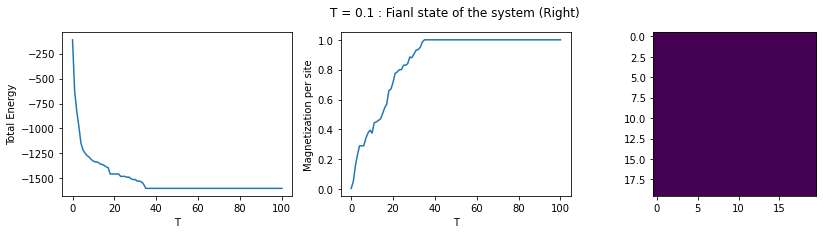

In [13]:
Lattice = np.random.choice([1, -1], size=(L,L), p=[p, 1-p])
Lattice1,E,M = Metropolis(Lattice,100,0.1,L)
x = np.arange(0,len(E),1)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
axes[0].plot(x,E)
axes[0].set_xlabel('T')
axes[0].set_ylabel('Total Energy')
axes[1].plot(x,M)
axes[1].set_xlabel('T')
axes[1].set_ylabel('Magnetization per site')
axes[2].imshow(Lattice1)
fig.tight_layout()
fig.suptitle('T = 0.1 : Fianl state of the system (Right)', x = 0.53, y = 1.07)
plt.show()

Looking at curves, to accurately estimate the expectation values i.e. extract the linear part of the curve, linear regression can be applied. By appliying linear regression from the left, the part of the curve having $R^2$ value greater than certain cutoff value was only considered and the mean of the values after that point was taken. The function was optimized considering for higher values of T, there is relatively high oscillation hence low $R^2$ value. 

In [14]:
#Estimate expectation value from the array of Energy and Magnetization
def Expectation(Energy,Magnetization,n):
    array = np.arange(0,len(Energy),1)
    n_min = 0
    for i in range(1,len(Energy)):
        linreg = scipy.stats.linregress(array[i:],Energy[i:])
        if(n <= 2 and (linreg.rvalue**2 > 0.95 or linreg.rvalue**2 < 0.02)):
            break
        if(n <= 4 and (linreg.rvalue**2 > 0.90 or linreg.rvalue**2 < 0.02)):
            break
        if(linreg.rvalue**2 > 0.90):
            break
        n_min += 1
    return(np.mean(Energy[n_min:]),np.mean(Magnetization[n_min:]),n_min)

n_min =  43


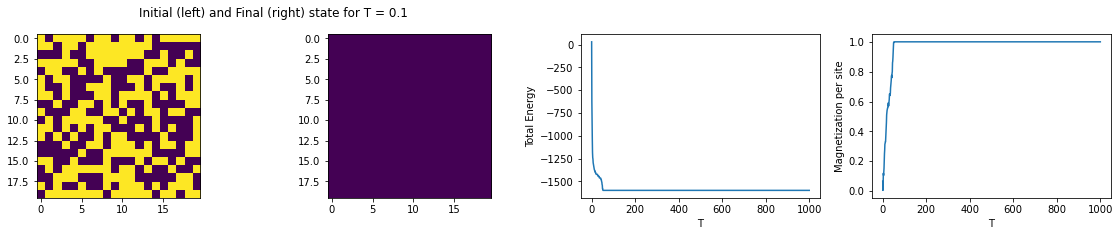

n_min =  44


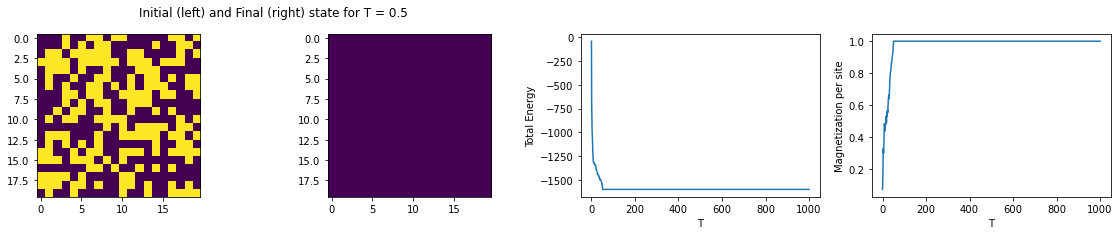

n_min =  45


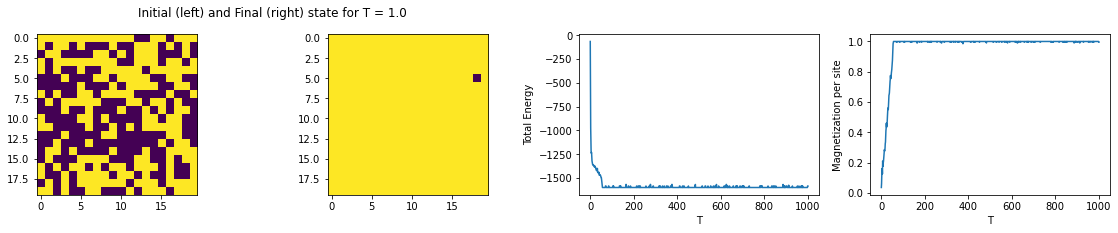

n_min =  254


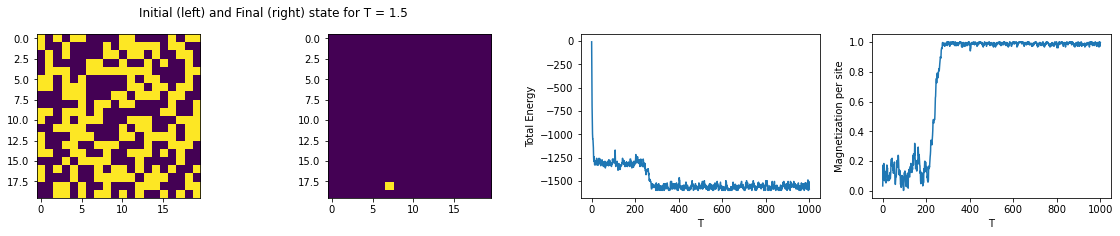

n_min =  12


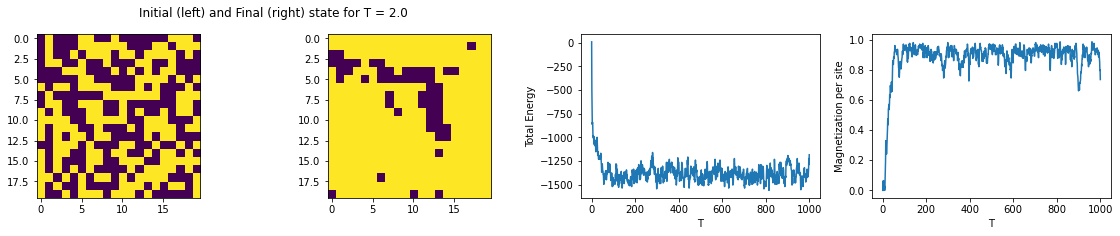

n_min =  998


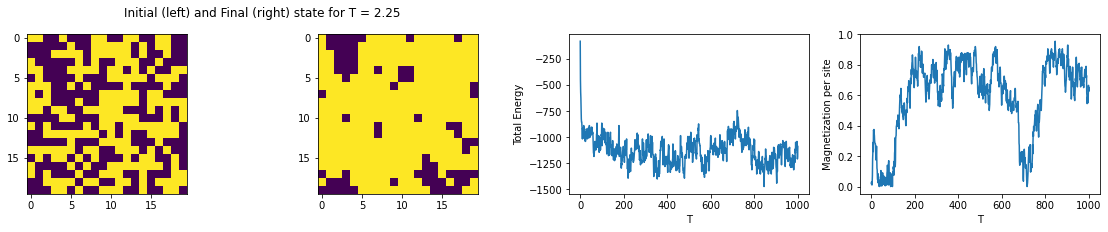

n_min =  998


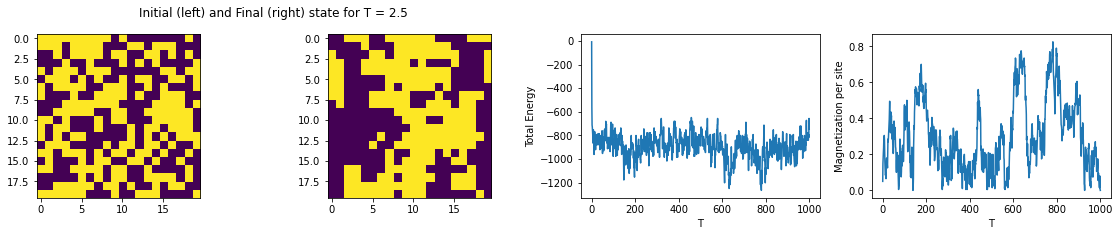

n_min =  998


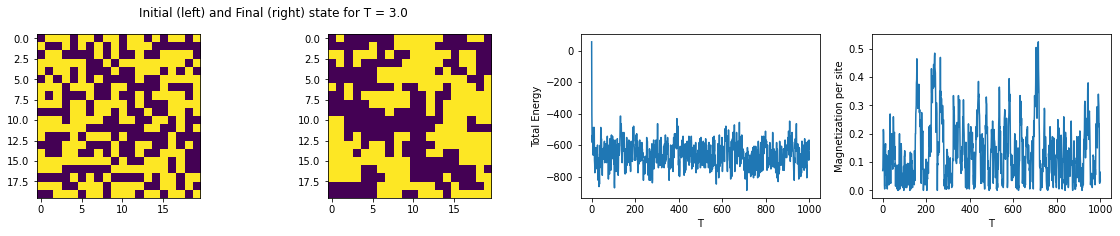

n_min =  996


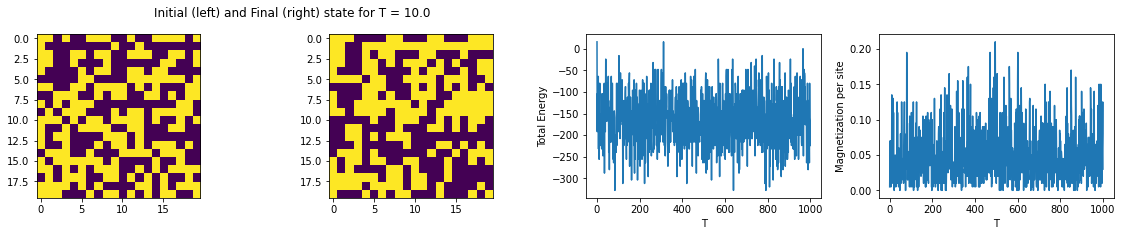

In [15]:
T = [0.1, 0.5, 1.0, 1.5, 2.0, 2.25, 2.5, 3.0, 10.0] 
La = []
energy = []
mag = []
E = [] 
M = []
for i in range(len(T)):
    Lattice = np.random.choice([1, -1], size=(L,L), p=[p, 1-p])
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 3))
    axes[0].imshow(Lattice)
    l,e,m = Metropolis(Lattice,1000,T[i],L)
    energy.append(e)
    mag.append(m)
    La.append(l)
    e1,m1,n_min = Expectation(e,m,i)
    E.append(e1)
    M.append(m1)
    print('n_min = ',n_min)
    axes[1].imshow(l)
    axes[2].plot(e)
    axes[2].set_xlabel('T')
    axes[2].set_ylabel('Total Energy')
    axes[3].plot(m)
    axes[3].set_xlabel('T')
    axes[3].set_ylabel('Magnetization per site')
    fig.tight_layout()
    plt.title('Initial (left) and Final (right) state for T = {:}'.format(T[i]),x = -2.5, y = 1.07)
    plt.show()

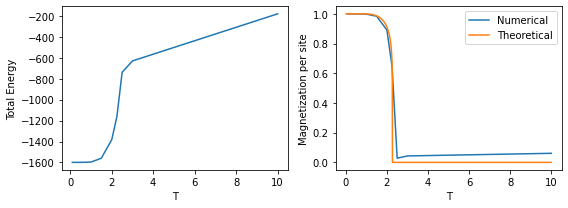

In [16]:
Tc = 2/np.log(1+2**(1/2))
X = np.arange(0.01,10,0.01)
MT = np.zeros(len(X))
for i in range(len(X)):
    if(X[i] - Tc < 0):
        MT[i] = (1 - (math.sinh(2/X[i]))**(-4))**(1/8)
    else:
        MT[i] = 0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
axes[0].plot(T,E)
axes[0].set_xlabel('T')
axes[0].set_ylabel('Total Energy')
axes[1].plot(T,M, label = 'Numerical')
axes[1].plot(X,MT,label = 'Theoretical')
axes[1].set_xlabel('T')
axes[1].set_ylabel('Magnetization per site')
fig.tight_layout()
plt.legend()
plt.show()

Obtaied numerical expectation for magnetization seems to be close to the theoretical predictions, however there are more fluctuations for higher values of T'. Which can be seen from the visulation of the states and also no convergence of magnetization can be seen in the plot of T' = 10.

Here For Lattice of size $20 \times 20$, 100 data points for expectation of Energy and magnetization is taken and plotted with their corresponding error bars.

In [64]:
L = 20
No = 100
energy_mean1 = []
energy_error1 = []
mag_mean1 = []
mag_error1 = []
n_min_mean1 = []
for i in range(len(T)):
    En = []
    Ma = []
    n = []
    for j in range(No):
        Lattice = np.random.choice([1, -1], size=(L,L), p=[p, 1-p])
        l,e,m = Metropolis(Lattice,1000,T[i],L)
        e1,m1,n_min = Expectation(e,m,i)
        En.append(e1)
        Ma.append(m1)
        n.append(n_min)
    energy_mean1.append(np.mean(En))
    energy_error1.append(statistics.stdev(En)/No**(1/2))
    mag_mean1.append(np.mean(Ma))
    mag_error1.append(statistics.stdev(Ma)/No**(1/2))
    n_min_mean1.append(np.mean(n))

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:174: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:176: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


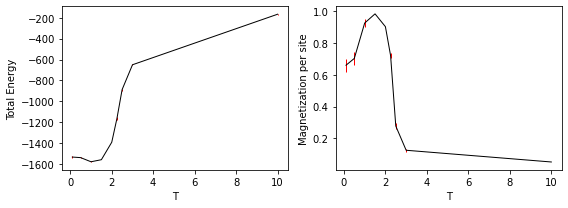

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
axes[0].errorbar(T,energy_mean1,color = 'k',linewidth = 1, yerr = energy_error1 ,ecolor='red')
axes[0].set_xlabel('T')
axes[0].set_ylabel('Total Energy')
axes[1].errorbar(T,mag_mean1,color = 'k',linewidth = 1, yerr = mag_error1 ,ecolor='red')
axes[1].set_xlabel('T')
axes[1].set_ylabel('Magnetization per site')
fig.tight_layout()
plt.show()

Here For Lattice of size $100 \times 100$, 100 data points for expectation of Energy and magnetization is taken and plotted with their corresponding error bars.

In [42]:
No = 100
energy_mean2 = []
energy_error2 = []
mag_mean2 = []
mag_error2 = []
n_min_mean2 = []
for i in range(len(T)):
    En = []
    Ma = []
    for j in range(No):
        Lattice = np.random.choice([1, -1], size=(100,100), p=[p, 1-p])
        l,e,m = Metropolis(Lattice,1000,T[i],100)
        e1,m1,n_min = Expectation(e,m,i)
        En.append(e1)
        Ma.append(m1)
        n.append(n_min)
    energy_mean2.append(np.mean(En))
    energy_error2.append(statistics.stdev(En)/No**(1/2))
    mag_mean2.append(np.mean(Ma))
    mag_error2.append(statistics.stdev(Ma)/No**(1/2))
    n_min_mean2.append(np.mean(n))

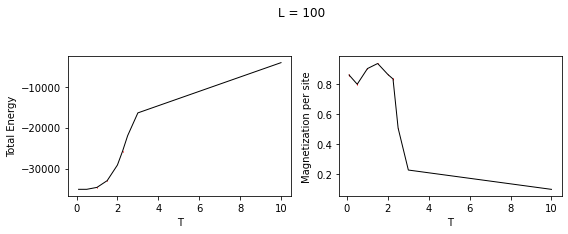

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
axes[0].errorbar(T,energy_mean2,color = 'k',linewidth = 1, yerr = energy_error2 ,ecolor='red')
axes[0].set_xlabel('T')
axes[0].set_ylabel('Total Energy')
axes[1].errorbar(T,mag_mean3,color = 'k',linewidth = 1, yerr = mag_error2 ,ecolor='red')
axes[1].set_xlabel('T')
axes[1].set_ylabel('Magnetization per site')
fig.suptitle('L = 100', x = 0.53, y = 1.07)
fig.tight_layout()
plt.show()

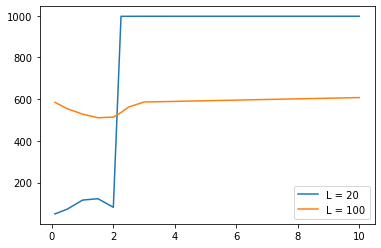

In [47]:
plt.plot(T,n_min_mean1,label= 'L = 20')
plt.plot(T,n_min_mean2,label='L = 100')
plt.legend()
plt.show()

The error bars in case of smaller lattice seems to be larger than that of bigger lattice and overall the expectation of magnetism seems to follow the theoretical predictions. For $n_{min}$ value, for smaller lattice it seems to increase with T but for bigger lattice seem somewhat constant. This could also be because expectation function was optimized for lattice of size 20 so actual convergence could be predicted more accurately.